In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import halo_tpf

import lightkurve as lk

import k2sc 

from astropy.table import Table
from astropy.io import fits

from astropy.timeseries import LombScargle
from scipy.signal import savgol_filter as savgol
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
from scipy import ndimage

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']
from mpl_toolkits.axes_grid1 import make_axes_locatable

print('matplotlib: {}'.format(matplotlib.__version__))
print('lk: {}'.format(lk.__version__))
print('k2sc: {}'.format(k2sc.__version__))
print('halophot: {}'.format(halophot.__version__))

Populating the interactive namespace from numpy and matplotlib
matplotlib: 3.4.2
lk: 2.0.11
k2sc: 1.0.2.2
halophot: 0.7.5


In [2]:
epic_id = "EPIC 200173871" 
name = "HR 1576" 
# epic_id = "EPIC 200173854" name = "15 Ori" - contaminating star
#name = "EPIC 200173871"#HR 1576 - contaminating star 
#name = "EPIC 200173856" #HR 1684 - contsminating star 
#name = "EPIC 200173860" #81 Tau - check weights
search_result = lk.search_targetpixelfile(epic_id, author="K2", cadence="long")

In [28]:
tpf = search_result[0].download()

In [29]:
fname = tpf.path

In [30]:
#download mask
fname_mask = "masks/ktwo200173871-c13_lpd-targ-custom-lc.fits"
custom_hdus = fits.open(fname_mask)
custom_mask = custom_hdus[2].data

In [7]:
#custom_mask
custom_mask_inv = np.full_like(custom_mask, 3)
custom_mask_inv[custom_mask==3] = 1
#with numpy.printoptions(threshold=numpy.inf):
#    print(custom_mask_inv)
#np.logical_not(custom_mask).astype(np.uint8)

<AxesSubplot:title={'center':'Target ID: 200173871, Cadence: 140879'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

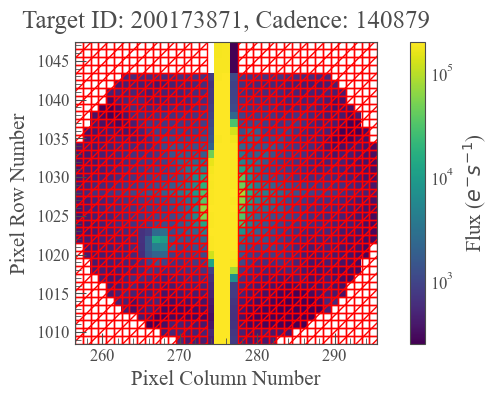

In [8]:
tpf = halo_tpf(fname)
tpf.plot(frame=1,aperture_mask=custom_mask_inv, scale = 'log')

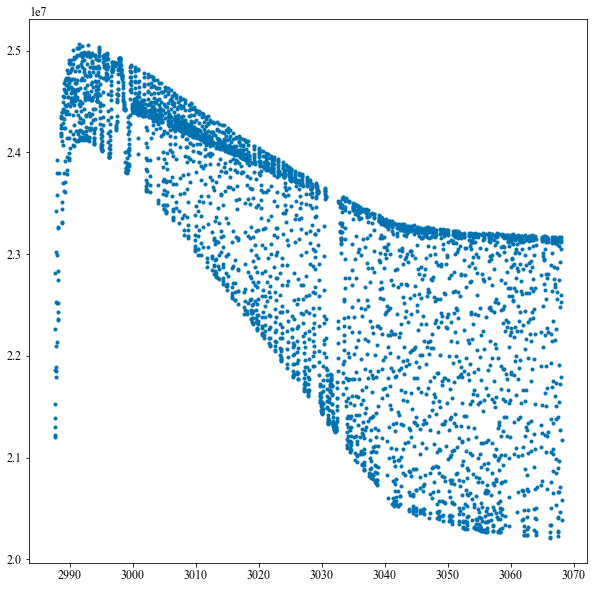

In [9]:
lc = tpf.to_lightcurve()
plt.plot(lc.time.value, lc.flux,'.')

In [10]:
%%time
meta, corr_lc = tpf.halo(thresh=0.5,lag=10,aperture_mask=custom_mask_inv);
weightmap = meta['weightmap']

Taking cadences from beginning to end
1 saturated pixels
Throwing out 3 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 17.7 s, sys: 12.9 s, total: 30.6 s
Wall time: 4.58 s


/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/halophot/halo_tools.py:1159: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_out.pos_corr1 = self.pos_corr1
/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/halophot/halo_tools.py:1160: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc_out.pos_corr2 = self.pos_corr2
/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/halophot/halo_tools.py:1162: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will 

/var/folders/q2/9w1c_jb920sf2pyq5t8xc9sw0000gp/T/ipykernel_94240/794867533.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap.set_bad('k',1.)


Text(0.5, 1.0, 'TV-min Weightmap')

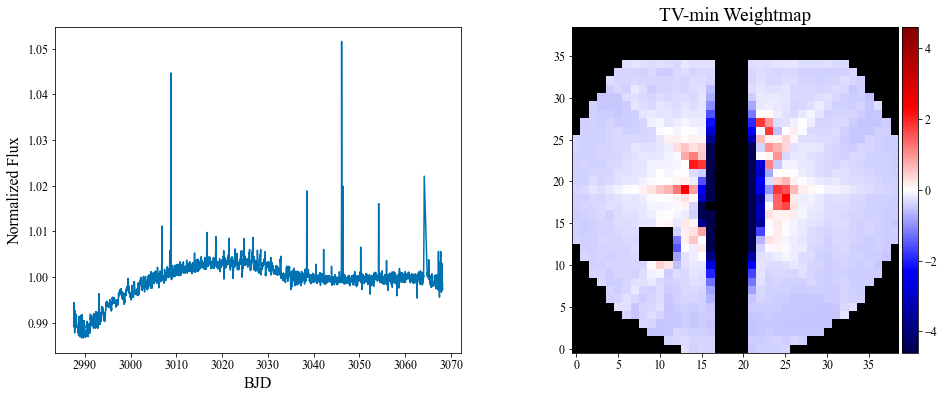

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16.0,6.0))

ax1.plot(corr_lc.time.value,corr_lc.flux)
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('BJD')
ax2.set_title('Light Curve')

cmap = mpl.cm.seismic
norm = np.size(weightmap)

cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
im2 = ax2.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

ax2.set_title('TV-min Weightmap')

In [65]:
from inspect import signature
t = signature(tpf.halo)
print(t)

(aperture_mask='pipeline', split_times=None, sub=1, maxiter=101, w_init=None, random_init=False, thresh=-1, minflux=-100.0, objective='tv', rr=None, analytic=True, sigclip=False, mask=None, verbose=True, lag=1, bitmask='default')


In [66]:
import k2sc
from k2sc.standalone import k2sc_lc

corr_lc.__class__ = k2sc_lc

In [67]:
corr_lc.k2sc()

Using default splits [2998, 3033] for campaign 13


/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/K2SC-1.0.2.2-py3.8.egg/k2sc/standalone.py:293: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.
/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/K2SC-1.0.2.2-py3.8.egg/k2sc/dtdata.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/K2SC-1.0.2.2-py3.8.egg/k2sc/dtdata.py:17: DeprecationWarning: `np.bool` is a deprecat

Starting initial outlier detection
  Flagged 74 ( 2.0%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =   11.51 (fap 6.8142e-169 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE


  0%|          | 0/150 [00:00<?, ?it/s]/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/K2SC-1.0.2.2-py3.8.egg/k2sc/de.py:85: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 45%|████▍     | 67/150 [02:37<03:15,  2.36s/it, -ln(L)=-4929.1]
/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/K2SC-1.0.2.2-py3.8.egg/k2sc/gp.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted

  DE finished in 157 seconds
  DE minimum found at: [-5.068e+00  9.703e-01  1.867e+01  1.297e-02 -4.649e+00  2.095e+01  3.812e+01 -3.433e+00]
  DE -ln(L) -4929.1
Starting local hyperparameter optimisation
  Local minimum found at: [-5.039e+00  9.685e-01  1.798e+01  1.038e-02 -4.654e+00  2.028e+01
  3.701e+01 -3.434e+00]


/Users/kote_electric/opt/anaconda3/lib/python3.8/site-packages/K2SC-1.0.2.2-py3.8.egg/k2sc/gp.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Starting final outlier detection
     30 too high
      4 too low
      3 not finite
Computing time and position trends
  CDPP - raw - 184.197
  CDPP - position component removed - 93.865
  CDPP - full reduction - 93.848
Detrending time 163.41812181472778


Text(0.5, 1.01, 'HR 1576')

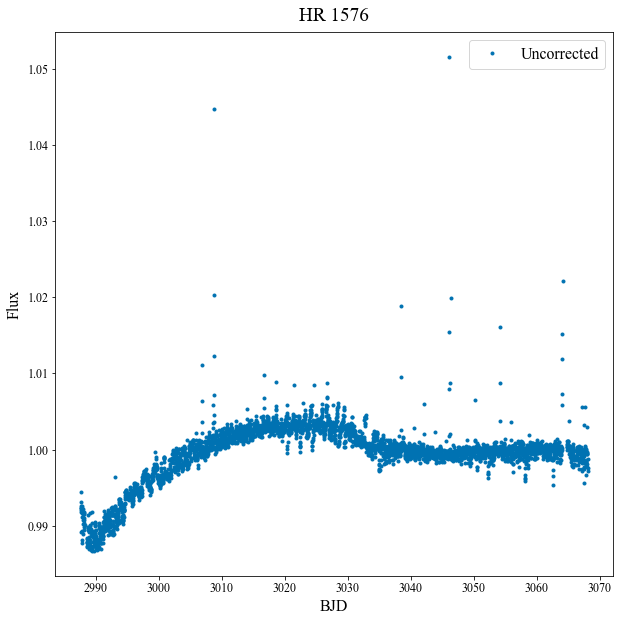

In [13]:
plt.plot(corr_lc.time.value,corr_lc.flux.value,'.',label="Uncorrected")
#plt.plot(corr_lc.time.value,corr_lc.corr_flux.value,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')

plt.title(name,y=1.01)

In [69]:
meta

{'initial_cadence': 140878,
 'final_cadence': 144821,
 'sat_pixels': 39,
 'weightmap': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [14]:
#m = np.isfinite(corr_lc.corr_flux.value)
m = np.isfinite(corr_lc.flux.value)

In [15]:
halo_time = corr_lc.time.value[m]
#halo_corr_flux = corr_lc.corr_flux.value[m]
halo_corr_flux = corr_lc.flux.value[m]

halo_normalized_flux = halo_corr_flux/np.nanmedian(halo_corr_flux)
halo_trend = savgol(halo_normalized_flux,201,3)

halo_lc = LombScargle(halo_time,halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend),normalization='standard') #+np.nanmedian(halo_trend)
freqs_halo = np.linspace((1/30.),24.,10000)
power_halo = halo_lc.power(freqs_halo)
max_freq_halo = np.round(freqs_halo[power_halo.argmax()], 3)

halo_smothed_periodogram = ndimage.gaussian_filter1d(power_halo,10)

In [16]:
#dowload tess
lc_search = lk.search_lightcurve(name,exptime=120)

lc = lc_search.download_all()
    
lc[0] = lc[0].remove_nans().normalize()
tess_time = lc[0].time.value
tess_flux = lc[0].flux.value

freqs_tess = np.linspace((1/10.),360.,10000) # tess from 10 day period to 360 c/d nyquist
ls_tess = LombScargle(tess_time, tess_flux, normalization='standard')
power_tess = ls_tess.power(freqs_tess)
max_freq_tess = np.round(freqs_tess[power_tess.argmax()], 3)

tess_smothed_periodogram = ndimage.gaussian_filter1d(power_tess,3)

/var/folders/q2/9w1c_jb920sf2pyq5t8xc9sw0000gp/T/ipykernel_94240/4033397847.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap.set_bad('k',1.)


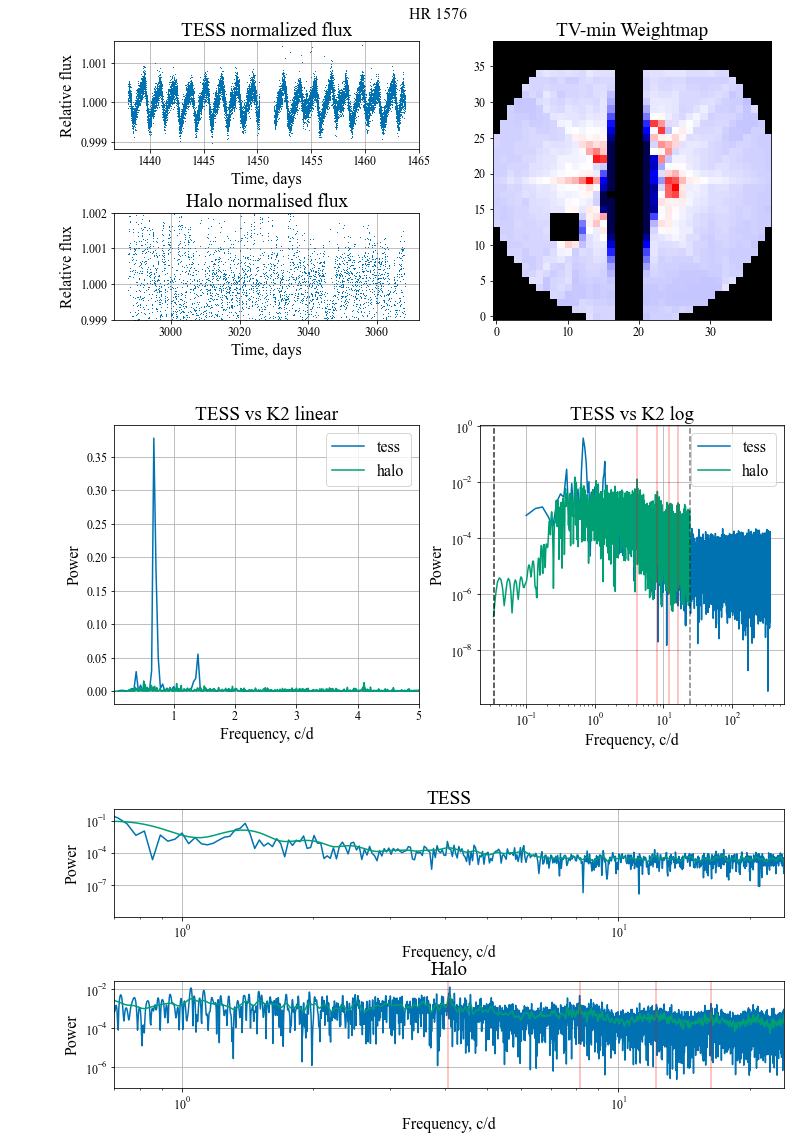

In [17]:
    fig = plt.figure(figsize=(12.0,16))
    fig.subplots_adjust(top=0.85)
    
    fig.suptitle(name, fontsize=16)
    
    figs = fig.subfigures(nrows=3, ncols=1)
    
    fig1 = figs[0]
    fig1.subplots_adjust(hspace=0.6)
    
    ax2 = fig1.add_subplot(122)
    
    cmap = mpl.cm.seismic
    norm = np.size(weightmap)

    cmap.set_bad('k',1.)
    im = np.log10(weightmap.T*norm)
    im2 = ax2.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
        interpolation='None',origin='lower')
    # divider = make_axes_locatable(ax2)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im2, cax=cax, orientation='vertical');
    ax2.set_title('TV-min Weightmap')
    
    
    ax1 = fig1.add_subplot(221)
    plt.plot(tess_time, tess_flux, ',')
    plt.yscale('linear')
    plt.ylabel('Relative flux')
    plt.xlabel('Time, days')
    plt.title('TESS normalized flux')
    plt.grid(True)

    #ax2 = fig1.add_subplot(222)
    #plt.plot(freqs_tess, power_tess)
    #plt.xscale('log')
    #plt.ylabel('Power')
    #plt.xlabel('Frequency, c/d')
    #plt.title('TESS, (max power freq %s)' %max_freq_tess)
    #plt.grid(True)

    ax3 = fig1.add_subplot(223)
    plt.plot(halo_time, halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend), ',')
    plt.ylim(0.999, 1.002)
    plt.yscale('linear')
    plt.ylabel('Relative flux')
    plt.xlabel('Time, days')
    plt.title('Halo normalised flux')
    plt.grid(True)

    #ax4 = fig1.add_subplot(224, sharex=ax2, sharey=ax2)
    #plt.plot(freqs_halo, power_halo)
    #plt.xscale('log')
    #plt.ylabel('Power')
    #plt.xlabel('Frequency, c/d')
    #plt.title('Halo, (max power freq %s)' %max_freq_halo)
    #plt.grid(True)

    fig2 = figs[1]
    ax8 = fig2.add_subplot(121)
    plt.plot(freqs_tess, power_tess, label="tess")
    plt.plot(freqs_halo, power_halo, label="halo")
    if name == "89 Tau":
        plt.xlim(1/30., 15.)
    elif name == "rho Tau":
        plt.xlim(1/30., 30.)
    else:
        plt.xlim(1/30., 5.)
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.legend(loc="upper right", )
    plt.title('TESS vs K2 linear')
    plt.grid(True)

    ax9 = fig2.add_subplot(122)
    plt.plot(freqs_tess, power_tess, label="tess")
    plt.plot(freqs_halo, power_halo, label="halo")
    plt.legend(loc="upper right", )
    plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
    #thruster fire harmonics
    plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
    plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
    plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
    plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.title('TESS vs K2 log')
    plt.grid(True)
    
    
    fig3 = figs[2]
    #fig3.suptitle('Smoothed', fontsize=16)
    ax5 = fig3.add_subplot(211)
    plt.plot(freqs_tess, power_tess, freqs_tess, tess_smothed_periodogram)
    plt.xlim(0.7, 24.)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('TESS')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.grid(True)

    ax6 = fig3.add_subplot(212)
    plt.plot(freqs_halo, power_halo, freqs_halo, halo_smothed_periodogram)
    plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
    plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
    plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
    plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
    plt.xlim(0.7, 24.)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Halo')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.grid(True)
    
    pp = PdfPages('%s.pdf' % (name))
    pp.savefig(fig)
    pp.close()

Text(0.5, 1.0, 'HR1576 without K2SC')

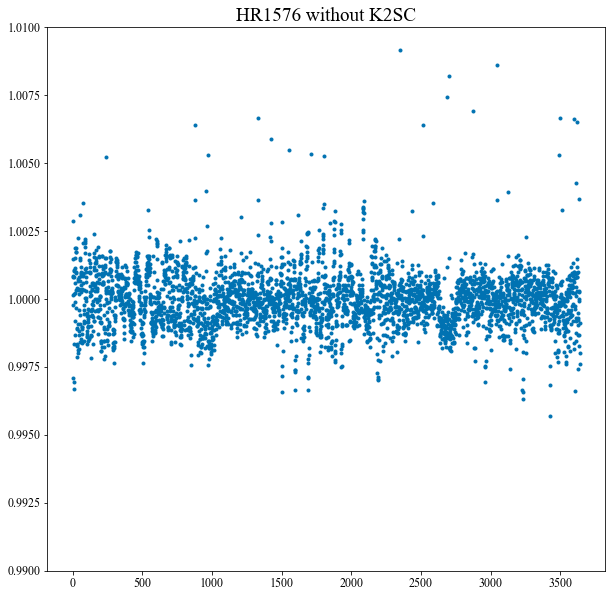

In [26]:
plt.plot(halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend), '.')
plt.ylim(0.99, 1.01)
plt.title('HR1576 without K2SC')


In [55]:
halo_trend

array([0.99794617, 0.99819106, 0.99842937, ..., 0.99449708, 0.99425451,
       0.99400756])

In [ ]:
len(halo_normalized_flux)

In [ ]:
savgol(halo_normalized_flux,301,3)

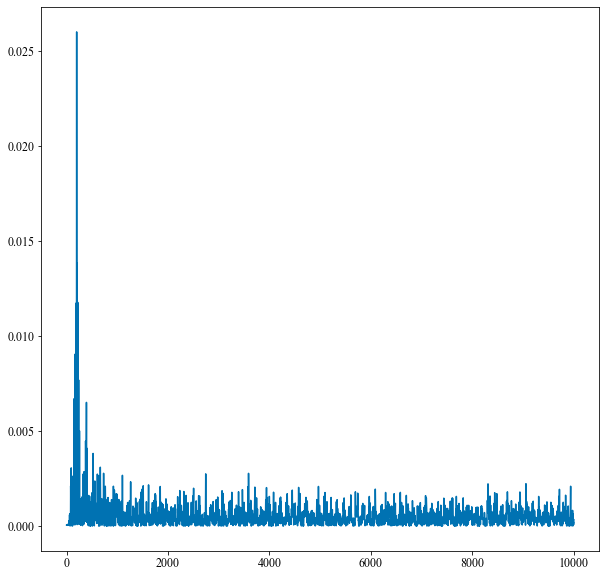

In [104]:
plt.plot(power_halo)

In [76]:
halo_corr_flux

array([0.996987  , 0.99710685, 0.99751819, ..., 0.99335085, 0.99314567,
       0.99352963])

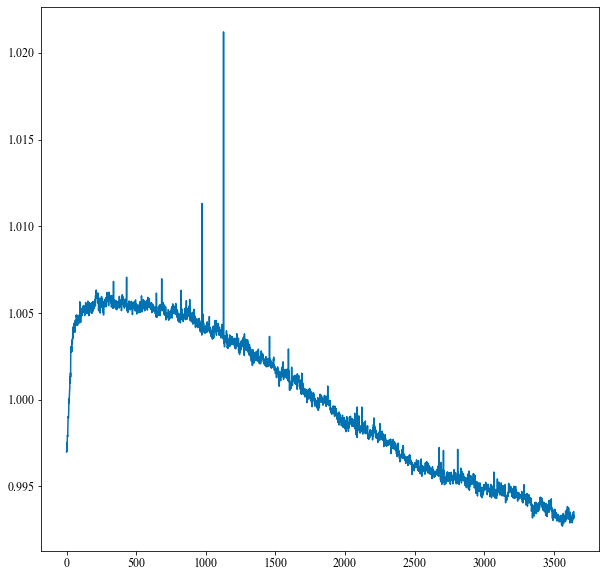

In [63]:
plt.plot(halo_corr_flux)

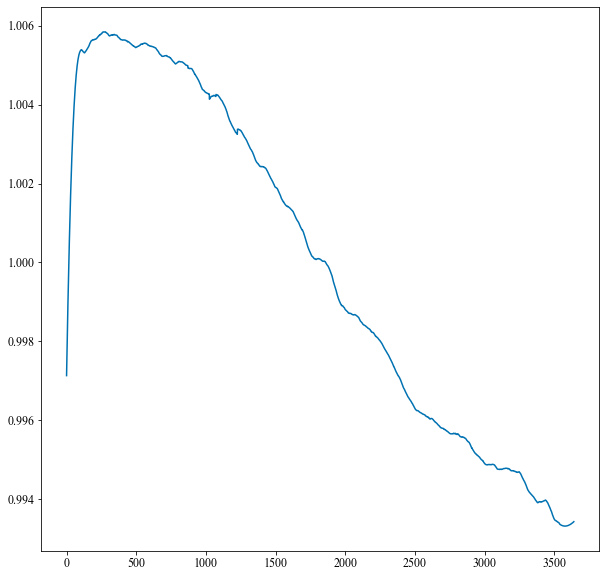

In [143]:
plt.plot(halo_trend)

In [75]:
numpy.sum(halo_normalized_flux) 

nan

In [79]:
corr_lc

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,,,,,,
object,float32,float32,float32,float32,int32,int32
2987.581674316927,0.9961825609207153,nan,-0.002630103,0.26483816,140878,917504
2987.6021068588307,0.9959062933921814,nan,-0.065448985,0.24085265,140879,393216
2987.62253920026,0.9961289167404175,nan,-0.12306208,0.21302728,140880,393216
2987.6429716412313,0.9955227971076965,nan,-0.18048273,0.18726316,140881,401408
2987.663404181272,0.9958921074867249,nan,-0.22894312,0.16502789,140882,393216
2987.6838365208387,0.996303379535675,nan,-0.27751163,0.1420407,140883,393216
...,...,...,...,...,...,...
3068.042125754524,0.9926484227180481,nan,-0.69820523,-0.08119749,144816,0
